In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

import deepxde as dde
from sklearn.model_selection import train_test_split

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
mx = 15
mt = 50
n = 110
x_range = 1
y_range = 10

In [3]:
x = np.linspace(0, x_range, mx)
y = np.linspace(0, y_range, mt)

In [4]:
seed = MasterRNG(123)
def one_function(x):
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [5]:
U_in = np.zeros((mx,n))
U = np.zeros((mx,mt,n))

for nn in range(n):
    x_values = one_function(x)
    U_in[:,nn] = x_values
    for tt in range(mt):
        U[:,tt,nn] = x_values

(15, 50)
(15, 50)


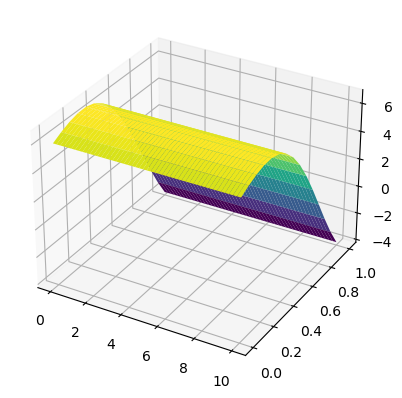

In [6]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, U[:,:,10], cmap='viridis')

In [7]:
S = np.zeros((mx,mt,n))
S = U
dx = abs(x[0]-x[1])
dt = abs(y[0]-y[1])
alpha = 0.01

for d in range(n):
    for t in range(1, mt-1):
        for i in range(1,mx-1):
            S[i, t + 1, d] = U[i, t, d] + alpha * (U[i + 1, t, d] - 2 * U[i, t, d] + U[i - 1, t, d]) * (dt / dx**2)

(15, 50)
(15, 50)


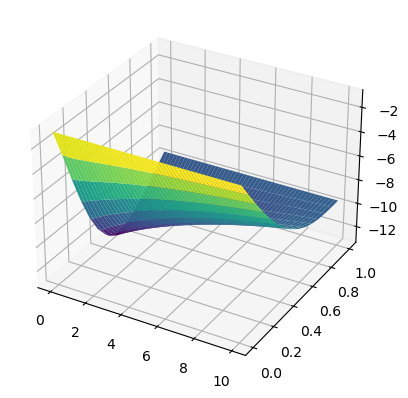

In [8]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,1], cmap='viridis')

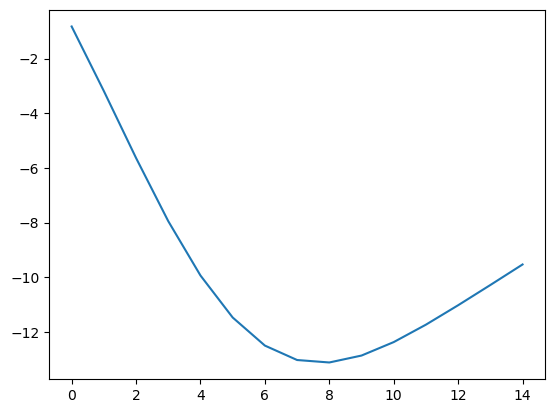

In [9]:
plt.plot(U_in[:,1])

In [10]:
x.shape, y.shape, S.shape, U_in.shape

((15,), (50,), (15, 50, 110), (15, 110))

In [11]:
combinations = []

for i in range(len(x)):
    for j in range(len(y)):
        combinations.append((x[i], y[j]))
        
combinations = np.array(combinations)
print(combinations.shape)
print(combinations)

(750, 2)
[[ 0.          0.        ]
 [ 0.          0.20408163]
 [ 0.          0.40816327]
 ...
 [ 1.          9.59183673]
 [ 1.          9.79591837]
 [ 1.         10.        ]]


In [12]:
x = combinations

In [13]:
x_space = np.linspace(0, x_range, mx)
y_space = np.linspace(0, y_range, mt)

In [14]:
def interate_dataset(mx=mx, mt=mt, n=n, x=x,U_in=U_in, U=U, S=S):
    us = np.zeros((mx*mt*n, mx))
    xs = np.zeros((mx*mt*n, 2))
    ss = np.zeros((mx*mt*n, 1))
    count = 0
    for i in range(n):
        for j in range(mx):
            for jj in range(mt):
                us[count,:] = U_in[:,i]
                xs[count] = [x_space[j],y_space[jj]]
                ss[count] = S[j, jj, i]
                count = count+1
                
    return us, xs, ss

In [15]:
us,xs,ss = interate_dataset()

In [16]:
us.shape, xs.shape, ss.shape

((82500, 15), (82500, 2), (82500, 1))

In [17]:
test_size = 0.2
us_train, us_test, xs_train, xs_test, ss_train, ss_test = train_test_split(us, xs, ss, test_size = test_size, random_state =42)

In [20]:
us_train.shape, us_test.shape,xs_train.shape,xs_test.shape,ss_train.shape,ss_test.shape

((66000, 15), (16500, 15), (66000, 2), (16500, 2), (66000, 1), (16500, 1))

In [23]:
type(ss_train)

numpy.ndarray

In [24]:
us_train = us_train.astype(np.float32)
us_test = us_test.astype(np.float32)

xs_train = xs_train.astype(np.float32)
xs_test = xs_test.astype(np.float32)

ss_train = ss_train.astype(np.float32)
ss_test = ss_test.astype(np.float32)

In [25]:
type(ss_train)

numpy.ndarray

In [26]:
X_train , y_train = (us_train,xs_train),ss_train
X_test , y_test = (us_test,xs_test),ss_test

In [27]:
data = dde.data.Triple(X_train=X_train,y_train=y_train, X_test=X_test, y_test=y_test)

In [28]:
m = mx
dim_x = 2

net = dde.nn.DeepONet( 
    [m,150,40],
    [dim_x,40,40],
    "relu",
    "Glorot normal",
)

In [29]:
model = dde.Model(data,net)

In [30]:
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.006792 s



In [31]:
losshistory, train_state = model.train(iterations = 13000)

Training model...



C:\Users\mecha\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss    Test loss     Test metric
0         [1.20e+02]    [1.21e+02]    []  
1000      [1.22e-01]    [1.20e-01]    []  
2000      [6.56e-02]    [6.66e-02]    []  
3000      [4.52e-02]    [4.53e-02]    []  
4000      [3.18e-02]    [3.19e-02]    []  
5000      [2.09e-02]    [2.12e-02]    []  
6000      [1.83e-02]    [1.84e-02]    []  
7000      [1.42e-02]    [1.43e-02]    []  
8000      [1.06e-02]    [1.09e-02]    []  
9000      [1.05e-02]    [1.09e-02]    []  
10000     [1.06e-02]    [1.11e-02]    []  
11000     [8.26e-03]    [8.71e-03]    []  
12000     [7.14e-03]    [7.59e-03]    []  
13000     [6.36e-03]    [6.73e-03]    []  

Best model at step 13000:
  train loss: 6.36e-03
  test loss: 6.73e-03
  test metric: []

'train' took 890.636179 s



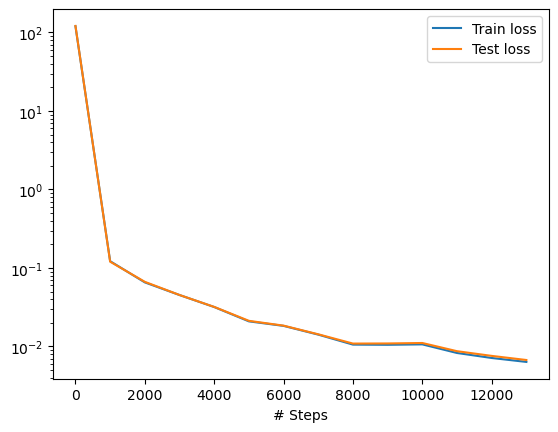

In [32]:
dde.utils.plot_loss_history(losshistory)

In [33]:
mx = 15
mt = 50
n = 110
x_range = 1
y_range = 10

In [34]:
x_gen = np.linspace(0, x_range, mx)
y_gen = np.linspace(0, y_range, mt)

In [35]:
seed = MasterRNG(321)
def one_function(x):
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [36]:
UU_in = np.zeros((mx,n))
UU = np.zeros((mx,mt,n))

for nn in range(n):
    x_values = one_function(x_gen)
    UU_in[:,nn] = x_values
    for tt in range(mt):
        UU[:,tt,nn] = x_values

In [37]:
# change the number here if want to see more
target_result = 6
################################################


U_gen = UU_in[:,target_result]

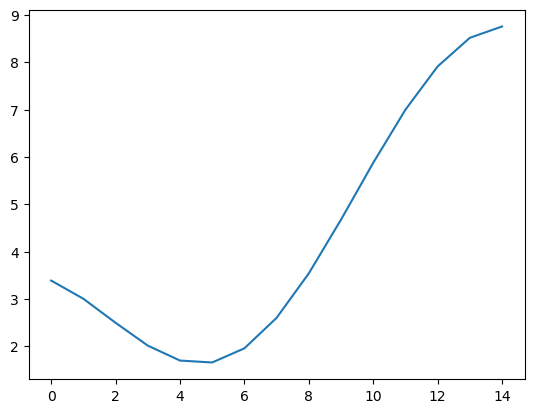

In [38]:
plt.plot(U_gen)

In [39]:
combinations = []

for i in range(len(x_gen)):
    for j in range(len(y_gen)):
        combinations.append((x_gen[i], y_gen[j]))
        
combinations = np.array(combinations)
print(combinations.shape)
print(combinations)

(750, 2)
[[ 0.          0.        ]
 [ 0.          0.20408163]
 [ 0.          0.40816327]
 ...
 [ 1.          9.59183673]
 [ 1.          9.79591837]
 [ 1.         10.        ]]


In [40]:
x = combinations

In [42]:
UU_in.shape, U_gen.shape

((15, 110), (15,))

In [43]:
array_length = mt*mx
U_gen_rep = np.vstack((U_gen,)*array_length)
print(U_gen_rep.shape)

(750, 15)


In [47]:
#U_gen

In [46]:
#U_gen_rep

In [48]:
result = model.predict((U_gen_rep,x))

In [49]:
result.shape

(750, 1)

In [51]:
#result

In [53]:
result =  result.reshape(mx, mt)

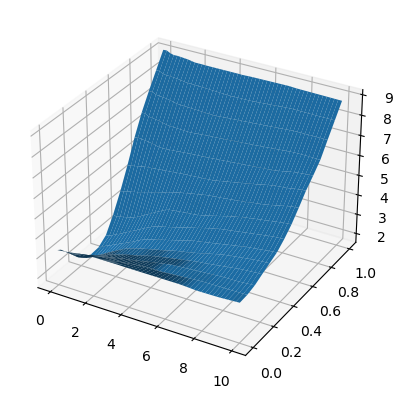

In [54]:
X, Y = np.meshgrid(y_gen,x_gen)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, result)

In [55]:
S = np.zeros((mx,mt,n))
S = UU
dx = abs(x_gen[0]-x_gen[1])
dt = abs(y_gen[0]-y_gen[1])
alpha = 0.01

for d in range(n):
    for t in range(1, mt-1):
        for i in range(1,mx-1):
            S[i, t + 1, d] = UU[i, t, d] + alpha * (UU[i + 1, t, d] - 2 * UU[i, t, d] + UU[i - 1, t, d]) * (dt / dx**2)

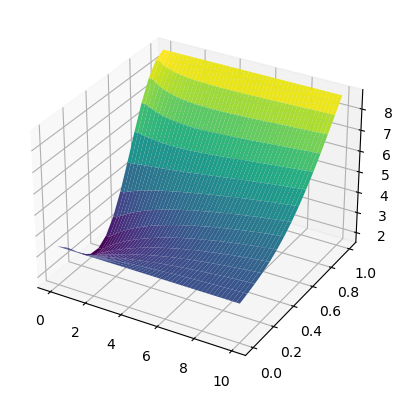

In [56]:
X, Y = np.meshgrid(y_gen,x_gen)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,target_result], cmap='viridis')

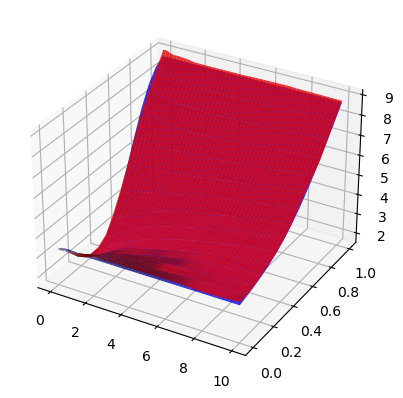

In [57]:
X, Y = np.meshgrid(y_gen,x_gen)

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

ax.plot_surface(X, Y, S[:,:,target_result], alpha=0.8, color = 'b')

ax.plot_surface(X, Y, result, alpha=0.8, color = 'r')

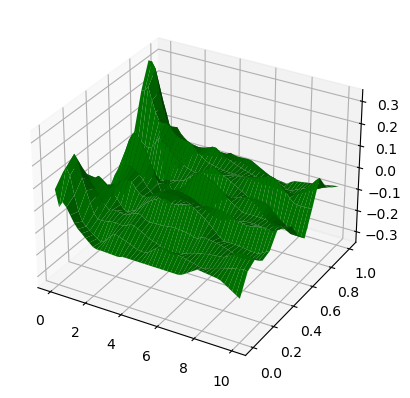

In [58]:
X, Y = np.meshgrid(y_gen,x_gen)

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

ax.plot_surface(X, Y, S[:,:,target_result]-result, alpha=1, color = 'g')